In [424]:
import pandas as pd
import torch
from d2l import torch as d2l
import numpy
from torch import nn
from torch.utils.data import dataloader, dataset

读取数据集

In [425]:
train_data = pd.read_csv('/Users/sunweixiang/Desktop/DeepLearing-with-pytorch/[6] House_price_pred/train.csv')
test_data = pd.read_csv('/Users/sunweixiang/Desktop/DeepLearing-with-pytorch/[6] House_price_pred/test.csv')

In [426]:
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

In [427]:
train_data.shape, test_data.shape

((1460, 81), (1459, 80))

清除id_row

In [428]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有均值消失，因此我们可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建指示符特征
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [429]:
n_train = train_data.shape[0]
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32, device='mps')
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32, device='mps')
train_labels = torch.tensor(
    train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32, device='mps'
    )

In [430]:
loss = nn.MSELoss()
in_features = train_features.shape[1]

def get_net():
    net = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features, 64),
        nn.ReLU(),
        nn.Dropout(0.2),
        nn.Linear(64, 1)
    )
    return net

In [431]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    rmse = torch.sqrt(loss(torch.log(clipped_preds),
                           torch.log(labels)))
    return rmse.item()

In [432]:
def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    net.to(torch.device('mps'))
    train_ls, test_ls = [], []
    train_ls = torch.zeros(num_epochs, device=torch.device('mps'))
    test_ls = torch.zeros(num_epochs, device=torch.device('mps'))
    train_iter = d2l.load_array((train_features, train_labels), batch_size)
    # Adam优化算法

    animator = d2l.Animator(xlabel='epoch', xlim=[1, num_epochs], ylim=[0, 1],
                        legend=['train loss', 'test loss', 'test acc'])

    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    for epoch in range(num_epochs):
        for X, y in train_iter:
            X = X.to(torch.device('mps'))
            y = y.to(torch.device('mps'))
            optimizer.zero_grad()
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
            d2l.train_ch3

        
        train_ls[epoch] = log_rmse(net, train_features, train_labels)
        if test_labels is not None:
            test_ls[epoch] = log_rmse(net, test_features, test_labels)

        animator.add(epoch + 1, (train_ls.cpu()[epoch], test_ls.cpu()[epoch],None))
            
    return train_ls, test_ls

In [433]:
def get_k_fold_data(k, i, X, y):
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        idx = slice(j * fold_size, (j + 1) * fold_size)
        X_part, y_part = X[idx, :], y[idx]
        if j == i:
            X_valid, y_valid = X_part, y_part
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

In [434]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            d2l.plot(list(range(1, num_epochs + 1)), [train_ls.cpu(), valid_ls.cpu()],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, '
              f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

折5，训练log rmse0.120120, 验证log rmse0.181764
5-折验证: 平均训练log rmse: 0.132127, 平均验证log rmse: 0.167965


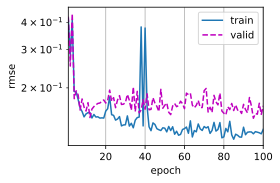

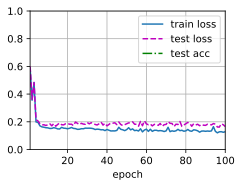

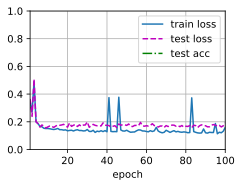

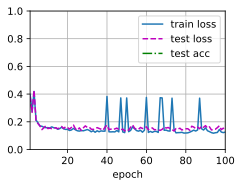

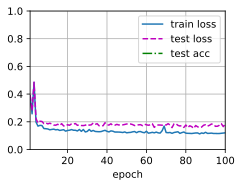

In [435]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 1, 10, 128
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

In [436]:
import numpy as np
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    d2l.plot(np.arange(1, num_epochs + 1), [train_ls.cpu()], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    preds = net(test_features).detach().cpu().numpy()
    # 将其重新格式化以导出到Kaggle
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)

训练log rmse：0.116755


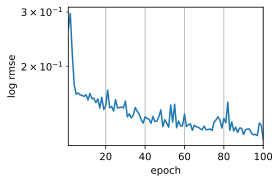

In [437]:
train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)